This notebook checks the overlap of methylated cytosines only.

# Imports

In [1]:
from pathlib import Path
from matplotlib_venn import venn3, venn2
import upsetplot
from matplotlib import pyplot as plt
from venn import venn

# Functions for reading in data

In [2]:
def read_bismark(file, frame, minimum_coverage, minimum_mods):
    """
    Reads output from Bismark Cytosine2coverage into 'bismark, chromosome_position, coverage, Nmods, context' format
    :param file: Bismark cytosine2coverage output
    :param frame: Empty list
    :param minimum_coverage: Minimum coverage for cytosine
    :param minimum_mods: Minimum number of methylated reads for cytosine
    :return: List where each row has information on a single cytosine that has at least x minimum_coverage and y Nmods 
    """
    with open(file, 'r') as content:
        for line in content:
            line = line.split() # chrom pos strand Nmod Ncanonical Ccontext trincontext
            
            chromosome = line[0]
            position = int(line[1])
            n_mod = int(line[3]) # N modified reads
            n_canonical = int(line[4]) # N non-modified reads
            context = line[5]
            
            coverage = n_mod + n_canonical
            if coverage >= minimum_coverage and n_mod >= minimum_mods:
                super_position = f'{chromosome}_{position - 1}' # position minus one to align with other tools
                frame.append(['bismark', super_position, coverage, n_mod, context])
            continue # if cov < min_coverage skip the line
    return frame


def read_bsmapz(file, frame, minimum_coverage, minimum_mods):
    """
    Reads output from BSmapz methratio.py into 'bsmapz, chromosome_position, coverage, Nmods, context' format
    :param file: Output of BSmapz methratio.py
    :param frame: Empty list
    :param minimum_coverage: Minimum coverage for cytosine
    :param minimum_mods: Minimum number of methylated reads for cytosine
    :return: List where each row has information on a single cytosine that has at least x minimum_coverage and y Nmods 
    """
    with open(file, 'r') as content:
        next(content) # Skip the header
        for line in content:
            line = line.split() # chrom, pos, strand, context, ratio, eff_CT_counts, c_counts, CT_counts, rev_G_counts, rev_GA_counts, CI_lower CI_upper
            
            chromosome = line[0]
            position = int(line[1])
            coverage = int(float(line[5]))
            n_mod = int(line[6])
            context = line[3]
            
            if coverage >= minimum_coverage and n_mod >= minimum_mods:
                super_position = f'{chromosome}_{position - 1}' # position minus one to align with other tools
                frame.append(['bsmapz', super_position, coverage, n_mod, context])
            continue # if cov < min_coverage skip the line
        return frame


def read_modkit(file, frame, minimum_coverage, minimum_mods): # modkit = Dorado & Guppy
    """
    Reads output from Modkit into 'modkit, chromosome_position, coverage, Nmods, context' format
    :param file: BED file output from Modkit
    :param frame: Empty list
    :param minimum_coverage: Minimum coverage for cytosine
    :param minimum_mods: Minimum number of methylated reads for cytosine
    :return: List where each row has information on a single cytosine that has at least x minimum_coverage and y Nmods 
    """
    with open(file, 'r') as content:
        for line in content:
            line = line.split() # chrom s_pos e_pos type score strand s_pos e_pos color coverage fraction_modified Nmod Ncanonical Nother_mod Ndelete Nfail Ndiff Nnocall
            
            chromosome = line[0]
            position = line[1]
            coverage = int(line[9])
            n_mod = int(line[11])
            
            if coverage >= minimum_coverage and n_mod >= minimum_mods:
                super_position = f'{chromosome}_{position}'
                frame.append(['modkit', super_position, coverage, n_mod, "CG"])
            continue # if cov < min_coverage skip the line
    return frame


def check_kmer(kmer):
    """
    Checks Kmer from DeepsignalPlant to determine cytosine context
    :param kmer: string from DeepsignalPlant
    :return: Context
    """
    if kmer[3] == 'G':
        context = 'CG'
    elif kmer[4] == 'G':
        context = 'CHG'
    else:
        context = 'CHH'
    return context

def read_dsp(file, frame, minimum_coverage, minimum_mods):
    """
    Reads output from Deepsignalplant call_freq into 'deepsignalplant, chromosome_position, coverage, Nmods, context' format
    :param file: Output from DeepsignalPlant call_freq
    :param frame: Empty list
    :param minimum_coverage: Minimum coverage for cytosine
    :param minimum_mods: Minimum number of methylated reads for cytosine
    :return: List where each row has information on a single cytosine that has at least x minimum_coverage and y Nmods 
    """
    with open(file, 'r') as content:
        for line in content:
            line = line.split() # chrom pos strand pos_in_strand prob_0_sum prob_1_sum Nmod Ncanonical coverage fraction_modified k_mer
            
            chromosome = line[0]
            position = line[1]
            coverage = int(line[8])
            n_mod = int(line[6])
            kmer = line[10]
            
            if coverage >= minimum_coverage and n_mod >= minimum_mods:
                super_position = f'{chromosome}_{position}'
                frame.append(['dsp', super_position, coverage, n_mod, check_kmer(kmer)])
            continue # if cov < min_coverage skip the line
    return frame


def read_bed(file, positions):
    """
    Read features from a BED file to compare their position to cytosine from methylation callers
    :param file: File in BED format
    :param positions: Empty list
    :return: List with every position a feature covers
    """
    with open(file, 'r') as content:
        for line in content:
            line = line.split()

            chromosome = line[0]
            start = int(line[1])
            end = int(line[2])

            for position in range(start, end):
                super_position = f'{chromosome}_{position}'
                positions.append(super_position)
    return set(positions)


# Functions for calculating intersections

In [3]:
def two_way_intersection(a, b):
    """
    Check intersection of two lists
    :param a: List 1
    :param b: List 2
    :return: Overlap, remainder a, remainder b
    """
    a = set(a)
    b = set(b)

    inter_ab = a & b
    
    a_remainder = a - b
    b_remainder = b - a
   
    return inter_ab, a_remainder, b_remainder

def three_way_intersection(a, b, c):
    """
    Check intersection of three lists
    :param a: list 1
    :param b: list 2
    :param c: list 3
    :return: Total intersection, intersection a+b, intersection b+c, intersection a+c, a remainder, b remainder, c remainder
    """
    a = set(a)
    b = set(b)
    c = set(c)

    # Calculate intersections
    inter_ab = a & b
    inter_bc = b & c
    inter_ac = a & c
    inter_abc = a & b & c

    # Calculate remainders
    a_remainder = a - (inter_ab | inter_ac)
    b_remainder = b - (inter_ab | inter_bc)
    c_remainder = c - (inter_bc | inter_ac)

    return inter_abc, inter_ab, inter_bc, inter_ac, a_remainder, b_remainder, c_remainder


In [4]:
def sort_positions(super_positions):
    """
    Sort super positions.
    :param super_positions: list of chromosome_position
    :return: returns sorted list of chromosome positions
    """
    tuple_pos = []
    for pos in super_positions:
        pos = pos.split('_')
        new_pos = (pos[0], int(pos[1]))
        tuple_pos.append(new_pos)
    return sorted(tuple_pos, key=lambda x: (x[0], x[1]))

In [5]:
def head(item):
    """
    Print first 10 lines of iterables
    :param item: Iterable object
    :return: None
    """
    for i in range(1,10):
        print(item[i])

# File paths

In [6]:
files = [Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/bismark_data/JR2.CX_report.txt'),                  # Bismark output
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/nanopore_data/dorado_methyl_ref_filter_fix.bed'),  # Dorado output
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/nanopore_data/C_call_mods_size.frequency.tsv'),    # DeepsignalPlant output
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/genome_data/verdahJR2.pilon6.fa'),                 # reference genome
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/nanopore_data/guppy_mods.bed'),                    # Guppy output
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/bismark_data/methratio_deduplicate.txt'),          # BSmapz output
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/genome_data/TE.bed'),                              # TE BED
         Path(r'/home/bayraktar/PycharmProjects/basecalling_scripts/data/genome_data/centromeres.bed')]                     # Centromere BED

# Read in the data

In [7]:
bismark = []
dorado = []
dsp = []
guppy = []
bsmapz = []

min_coverage = 4
min_Nmod = 3

bismark = read_bismark(files[0], bismark, min_coverage, min_Nmod)
dorado = read_modkit(files[1], dorado, min_coverage, min_Nmod)
dsp = read_dsp(files[2], dsp, min_coverage, min_Nmod)
guppy = read_modkit(files[4], guppy, min_coverage, min_Nmod)
bsmapz = read_bsmapz(files[5], bsmapz, min_coverage, min_Nmod)

In [8]:
head(bismark)

['bismark', '1_3404', 388, 4, 'CHH']
['bismark', '1_3411', 488, 4, 'CHH']
['bismark', '1_3421', 695, 5, 'CHH']
['bismark', '1_3424', 750, 4, 'CHH']
['bismark', '1_3429', 753, 4, 'CHH']
['bismark', '1_3433', 941, 8, 'CHG']
['bismark', '1_3434', 957, 4, 'CHH']
['bismark', '1_3435', 830, 3, 'CHH']
['bismark', '1_3436', 846, 9, 'CHH']


# Get the positions

In [9]:
bismark_pos = [row[1] for row in bismark]
bismark_pos_CG = [row[1] for row in bismark if row[4] == 'CG']

dsp_pos = [row[1] for row in dsp]
dsp_pos_CG = [row[1] for row in dsp if row[4] == 'CG']

dorado_pos = [row[1] for row in dorado]

guppy_pos = [row[1] for row in guppy]

bsmapz_pos = [row[1] for row in bsmapz]
bsmapz_pos_CG = [row[1] for row in bsmapz if row[4] == 'CG']


te_pos = read_bed(files[6], [])
ce_pos = read_bed(files[7], [])

# Check positions overlap with TE

/home/bayraktar/mambaforge/envs/basecalling/lib/python3.12/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['#F3965E' '#F3965E' '#ffcd002e' '#ffcd002e' '#F3965E' '#F3965E' '#F3965E'
 '#F3965E' '#F3965E' '#F3965E' '#ffcd002e' '#ffcd002e' '#F3965E'
 '#ffcd002e' '#ffcd002e' '#ffcd002e' '#F3965E' '#F3965E' '#ffcd002e'
 '#FFCD00' '#FFCD00' '#FFCD00' '#ffcd002e' '#ffcd002e' '#F3965E'
 '#ffcd002e' '#F3965E' '#F3965E' '#ffcd002e' '#ffcd002e' '#F3965E'
 '#F3965E' '#ffcd002e' '#F3965E' '#ffcd002e' '#ffcd002e' '#F3965E'
 '#F3965E' '#F3965E' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e'
 '#ffcd002e' '#ffcd002e' '#ffcd002e' '#FFCD00' '#FFCD00' '#F3965E'
 '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#F3965E' '#F3965E'
 '#ffcd002e' '#ffcd002e' '#ffcd002e' '#F3965E' '#ffcd002e' '#ffcd002e'
 '#ffcd002e' '#FFCD00' '#FFCD00' '#ffcd002e' '#ffcd002e' '#ffcd002e'
 '#FFCD00' '#ffcd002e' '#FFCD

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: xlabel='Intersection size'>}

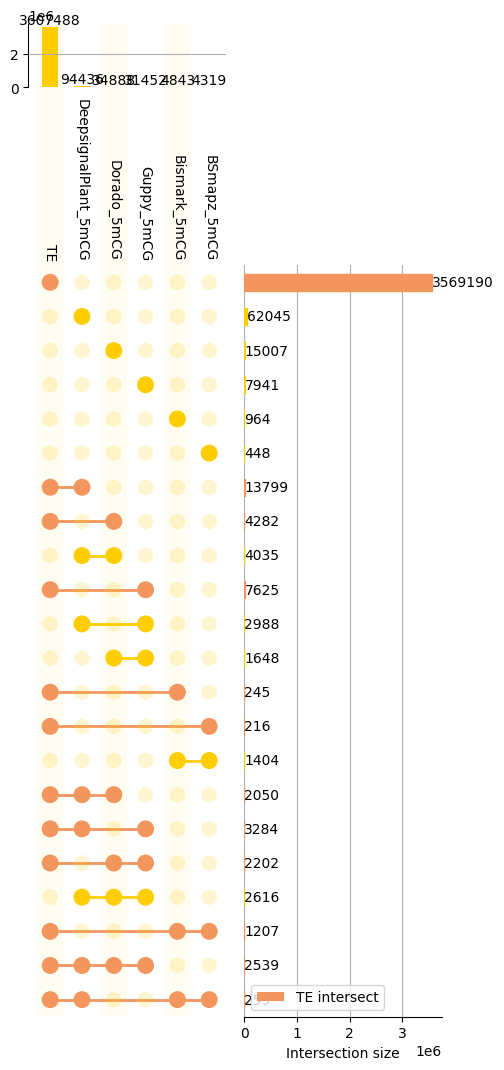

In [18]:
datadict = {'Bismark_5mCG': bismark_pos_CG,
            'DeepsignalPlant_5mCG': dsp_pos_CG,
            "Dorado_5mCG": dorado_pos,
            'Guppy_5mCG': guppy_pos,
            'BSmapz_5mCG': bsmapz_pos_CG,
            'TE': te_pos}
data = upsetplot.from_contents(datadict)
upset = upsetplot.UpSet(data, show_counts=True, facecolor="#FFCD00", orientation='vertical', min_subset_size=100)
# upset.style_subsets(present=["Dorado_5mCG", "Guppy_5mCG", "DeepsignalPlant_5mCG"], absent=["Bismark_5mCG", "BSmapz_5mCG"],facecolor="#AA1555",label="Nanopore intersect")
# upset.style_subsets(present=["Bismark_5mCG", "BSmapz_5mCG"], absent=["Dorado_5mCG", "Guppy_5mCG", "DeepsignalPlant_5mCG"],facecolor="#F3965E",label="Bisulfite intersect")
upset.style_subsets(present=["TE"],facecolor="#F3965E",label="TE intersect")
upset.plot()

In [10]:
overlap = two_way_intersection(dsp_pos, te_pos)
print(f'{len(overlap[0])}, {len(dsp_pos)}, {len(overlap[0])/len(dsp_pos)}')

54922, 150729, 0.3643758002773189


In [33]:
overlap = two_way_intersection(dorado_pos, te_pos)
print(f'{len(overlap[0])}, {len(dorado_pos)}, {len(overlap[0])/len(dorado_pos)}')

11378, 34888, 0.3261293281357487


In [35]:
overlap = two_way_intersection(guppy_pos, te_pos)
print(f'{len(overlap[0])}, {len(guppy_pos)}, {len(overlap[0])/len(guppy_pos)}')

15998, 31452, 0.5086480986900674


In [36]:
overlap = two_way_intersection(bismark_pos, te_pos)
print(f'{len(overlap[0])}, {len(bismark_pos)}, {len(overlap[0])/len(bismark_pos)}')

2529, 11860, 0.21323777403035413


In [37]:
overlap = two_way_intersection(bsmapz_pos, te_pos)
print(f'{len(overlap[0])}, {len(bsmapz_pos)}, {len(overlap[0])/len(bsmapz_pos)}')

2898, 9305, 0.31144545943041374


<Axes: >

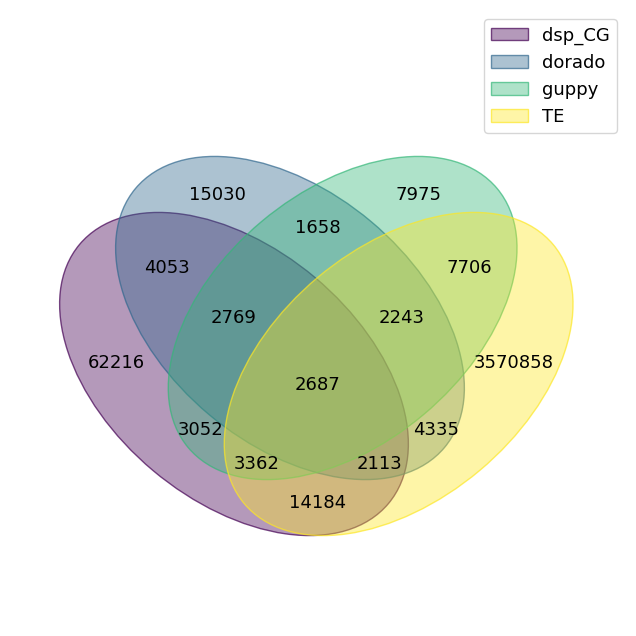

In [41]:
mc = {'dsp_CG': set(dsp_pos_CG), 'dorado': set(dorado_pos), 'guppy': set(guppy_pos), 'TE': set(te_pos)}
venn(mc)

In [30]:
TE_minus_ce = set(te_pos) - set(ce_pos)
print(len(TE_minus_ce))

2445473


<Axes: >

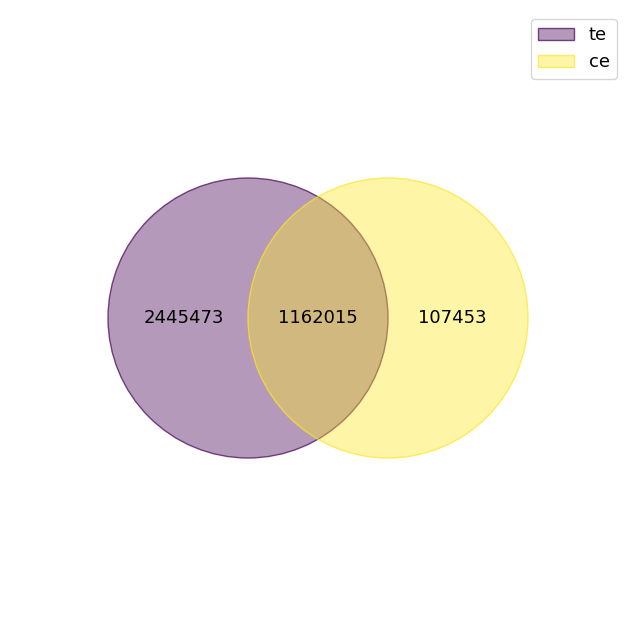

In [32]:
mc = {'te': set(te_pos), 'ce': set(ce_pos)}
venn(mc)

<Axes: >

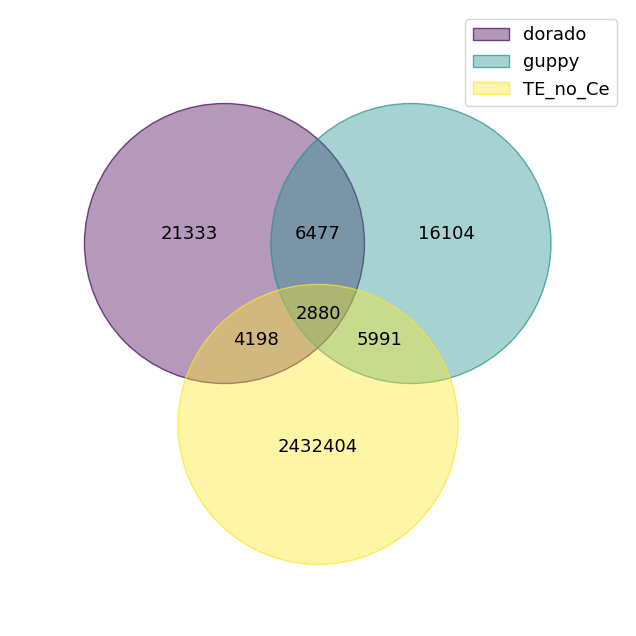

In [31]:
mc = {'dorado': set(dorado_pos), 'guppy': set(guppy_pos), 'TE_no_Ce': set(TE_minus_ce)}
venn(mc)


<Axes: >

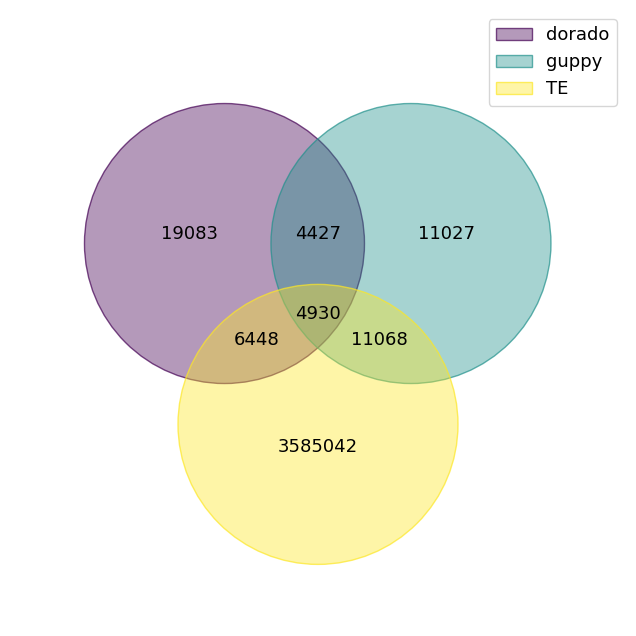

In [28]:
mc = {'dorado': set(dorado_pos), 'guppy': set(guppy_pos), 'TE': set(te_pos)}
venn(mc)

<Axes: >

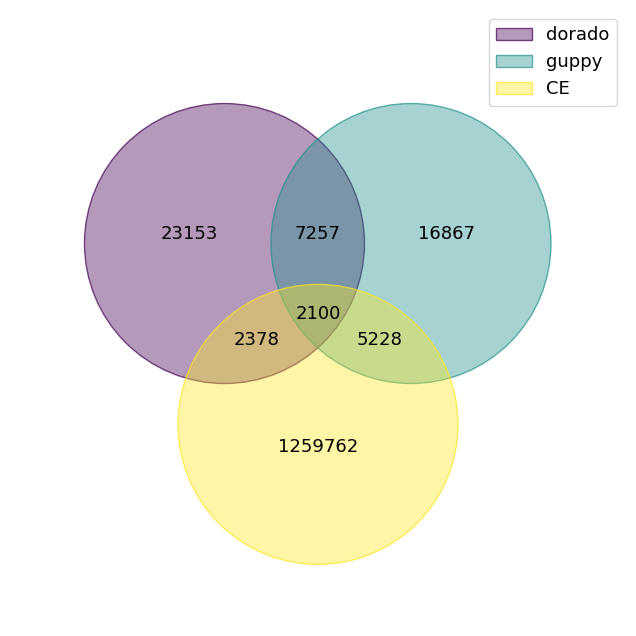

In [29]:
mc = {'dorado': set(dorado_pos), 'guppy': set(guppy_pos),'CE' : set(ce_pos)}
venn(mc)


<Axes: >

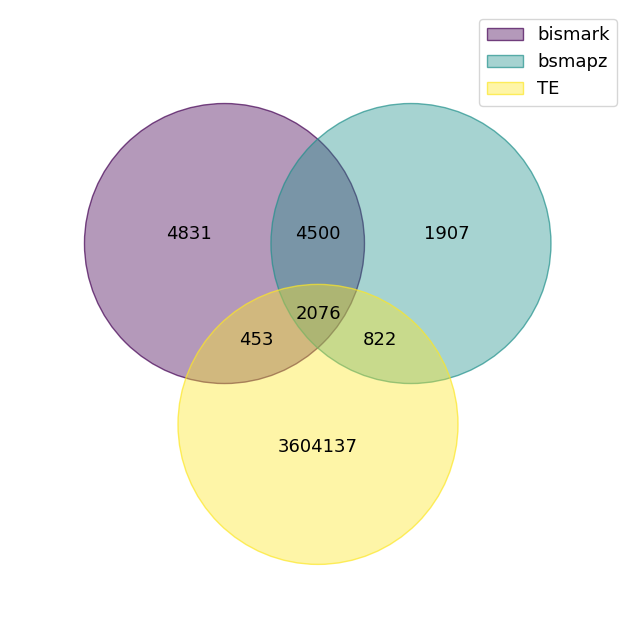

In [48]:
mc = {'bismark': set(bismark_pos), 'bsmapz': set(bsmapz_pos),'TE': set(te_pos)}
venn(mc)

# Plot tool overlap

/home/bayraktar/mambaforge/envs/basecalling/lib/python3.12/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['#FFCD00' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e'
 '#FFCD00' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e'
 '#FFCD00' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e'
 '#FFCD00' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#ffcd002e'
 '#FFCD00' '#FFCD00' '#FFCD00' '#ffcd002e' '#ffcd002e' '#ffcd002e'
 '#FFCD00' '#ffcd002e' '#FFCD00' '#ffcd002e' '#ffcd002e' '#ffcd002e'
 '#FFCD00' '#FFCD00' '#ffcd002e' '#ffcd002e' '#FFCD00' '#ffcd002e'
 '#ffcd002e' '#FFCD00' '#ffcd002e' '#ffcd002e' '#FFCD00' '#ffcd002e'
 '#FFCD00' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#FFCD00' '#FFCD00'
 '#ffcd002e' '#FFCD00' '#ffcd002e' '#ffcd002e' '#ffcd002e' '#FFCD00'
 '#ffcd002e' '#FFCD00' '#ffcd002e' '#ffcd002e' '#FFCD00' '#ffcd002e'
 '#ffcd002e' '#FFCD00

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

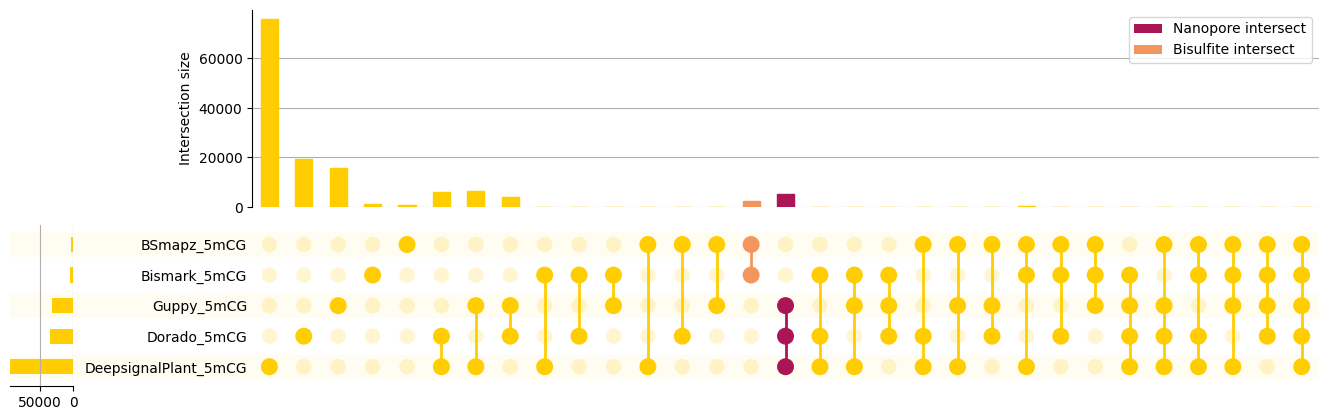

In [26]:
datadict = {'Bismark_5mCG': bismark_pos_CG,
            'DeepsignalPlant_5mCG': dsp_pos_CG,
            "Dorado_5mCG": dorado_pos,
            'Guppy_5mCG': guppy_pos,
            'BSmapz_5mCG': bsmapz_pos_CG}
data = upsetplot.from_contents(datadict)
upset = upsetplot.UpSet(data, show_counts=False, facecolor="#FFCD00")
upset.style_subsets(present=["Dorado_5mCG", "Guppy_5mCG", "DeepsignalPlant_5mCG"], absent=["Bismark_5mCG", "BSmapz_5mCG"],facecolor="#AA1555",label="Nanopore intersect")
upset.style_subsets(present=["Bismark_5mCG", "BSmapz_5mCG"], absent=["Dorado_5mCG", "Guppy_5mCG", "DeepsignalPlant_5mCG"],facecolor="#F3965E",label="Bisulfite intersect")
upset.plot()

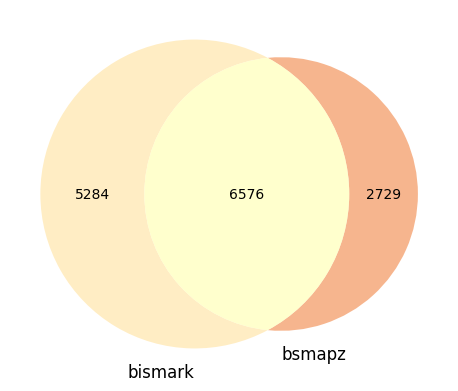

In [27]:
venn2([set(bismark_pos), set(bsmapz_pos)], ('bismark', 'bsmapz'),set_colors=('#FFE6AB', '#F3965E', '#AA1555'), alpha = 0.7)

Text(0.5, 1.0, 'Methylated cytosine overlap')

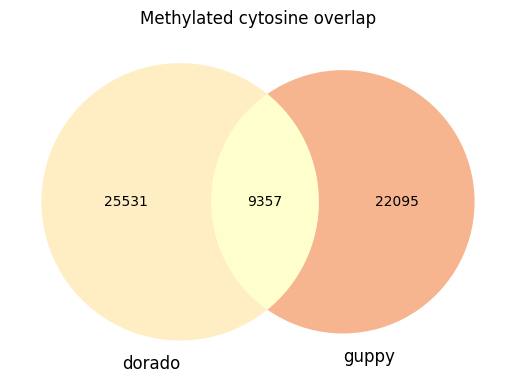

In [28]:
venn2([set(dorado_pos), set(guppy_pos)], ('dorado', 'guppy'),set_colors=('#FFE6AB', '#F3965E', '#AA1555'), alpha = 0.7)
plt.title('Methylated cytosine overlap')

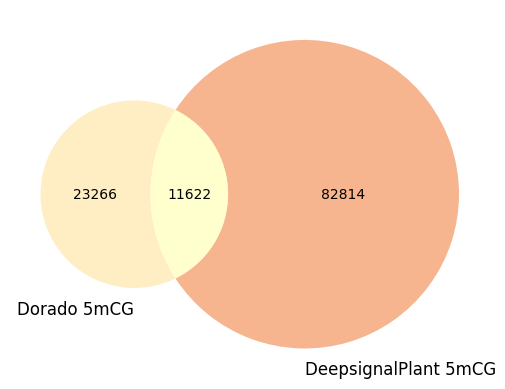

In [29]:
v = venn2([set(dorado_pos), set(dsp_pos_CG)], ('Dorado 5mCG','DeepsignalPlant 5mCG'), set_colors=('#FFE6AB', '#F3965E'), alpha = 0.7)

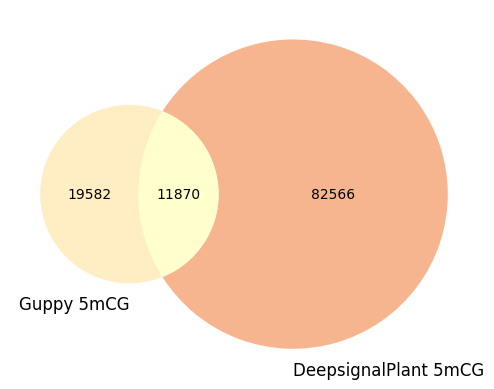

In [30]:
v = venn2([set(guppy_pos), set(dsp_pos_CG)], ('Guppy 5mCG','DeepsignalPlant 5mCG'), set_colors=('#FFE6AB', '#F3965E'), alpha = 0.7)

Text(0.5, 1.0, 'Methylated cytosine overlap')

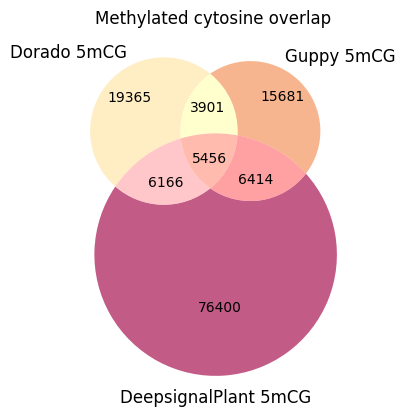

In [31]:
v = venn3([set(dorado_pos), set(guppy_pos), set(dsp_pos_CG)], ('Dorado 5mCG', 'Guppy 5mCG', 'DeepsignalPlant 5mCG'), set_colors=('#FFE6AB', '#F3965E', '#AA1555'), alpha = 0.7)
plt.title('Methylated cytosine overlap')

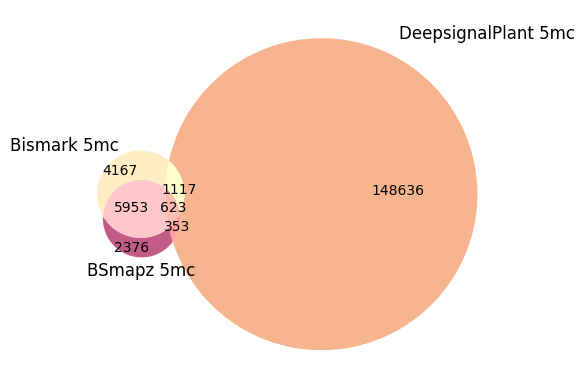

In [11]:
venn3([set(bismark_pos), set(dsp_pos), set(bsmapz_pos)], ('Bismark 5mc', 'DeepsignalPlant 5mc', 'BSmapz 5mc'), set_colors=('#ffe6ab', '#f3965e', '#aa1555'), alpha = 0.7)
# plt.title('Methylated cytosine overlap')